In [1]:
import contextlib
import dataclasses
import time

import numpy as np
import matplotlib.pyplot as plt

from qutip import *
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver
from IPython.display import display
from ipywidgets import IntProgress

%matplotlib inline


In [2]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [3]:

def state_current(ado_state, bath_tag):
    """ Determine current from the given bath (either "R" or "L") to
        the system in the given ADO state.
    """
    level_1_aux = [
        (ado_state.extract(label), ado_state.exps(label)[0])
        for label in ado_state.filter(level=1, tags=[bath_tag])
    ]

    def exp_sign(exp):
        return 1 if exp.type == exp.types["+"] else -1

    def exp_op(exp):
        return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

    return -1.0j * sum(
        exp_sign(exp) * (exp_op(exp) * aux).tr() for aux, exp in level_1_aux
    )


In [4]:
options = {
    "nsteps": 1500,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

In [5]:
@dataclasses.dataclass
class SystemParameters:
    e1: float = -5  
    U: float = 10  
    Nbos: int = 2

    def __post_init__(self):
        d_up = tensor(destroy(2), qeye(self.Nbos))
        sz = sigmaz()
        d_dn = tensor(-sz, destroy(2))
        self.H = (
            self.e1 * (d_up.dag() * d_up +
            d_dn.dag() * d_dn) +
            self.U * (d_up.dag() * d_up * d_dn.dag() * d_dn)
        )
        self.Q1 = d_up
        self.Q2 = d_dn
        self.Q = d_up + d_dn

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


sys_p = SystemParameters()

In [6]:
@dataclasses.dataclass
class LorentzianBathParameters:
    lead: str
    Q: object  # coupling operator
    gamma: float = 2.0  # coupling strength default 2.0
    W: float = 2  # cut-off
    T: float = 0.025851991  # temperature (in eV)
    theta: float = 2  # bias

    def __post_init__(self):
        assert self.lead in ("L", "R")
        self.beta = 1 / self.T
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = -self.theta / 2.0

    def J(self, w):
        """ Spectral density. """
        return self.gamma * self.W**2 / ((w - self.mu)**2 + self.W**2)

    def fF(self, w, sign=1.0):
        """ Fermi distribution for this bath. """
        x = sign * self.beta * (w - self.mu)
        return fF(x)

    def lamshift(self, w):
        """ Return the lamb shift. """
        return 0.5 * (w - self.mu) * self.J(w) / self.W

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


def fF(x):
    """ Return the Fermi distribution. """
    # in units where kB = 1.0
    return 1 / (np.exp(x) + 1)


# We set W = 1e4 to investigate the wide-band limit:

d_up = tensor(destroy(2), qeye(2))
sz = sigmaz()
d_dn = tensor(-sz, destroy(2))

bath_L = LorentzianBathParameters(Q=sys_p.Q1, lead="L")
bath_R = LorentzianBathParameters(Q=sys_p.Q2, lead="R")
bath_T = LorentzianBathParameters(Q=sys_p.Q, lead="L")

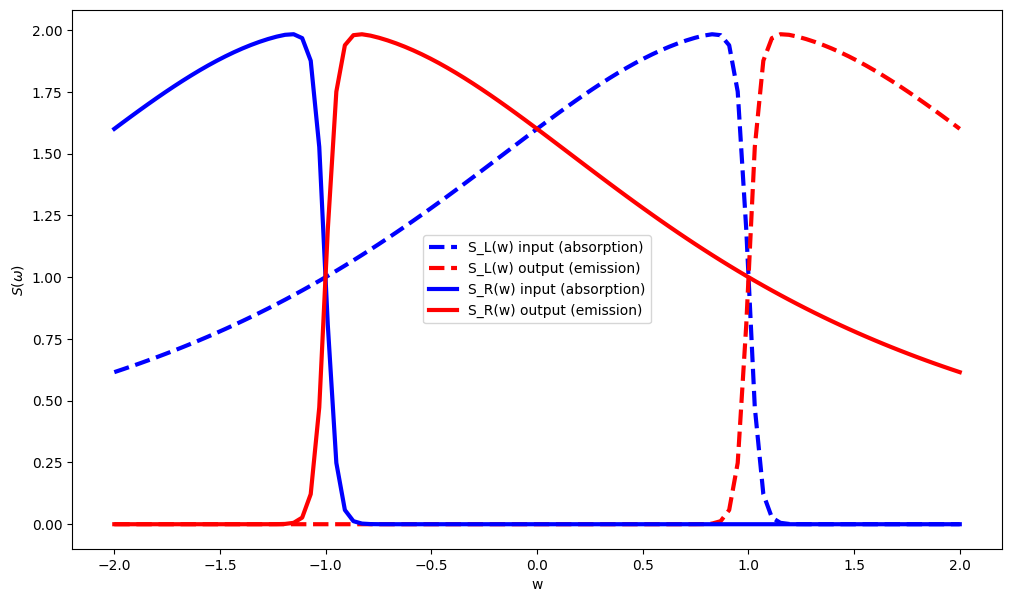

In [7]:
w_list = np.linspace(-2, 2, 100)

fig, ax = plt.subplots(figsize=(12, 7))

# Left lead emission and absorption

gam_L_in = bath_L.J(w_list) * bath_L.fF(w_list, sign=1.0)
gam_L_out = bath_L.J(w_list) * bath_L.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_L_in,
    "b--", linewidth=3,
    label=r"S_L(w) input (absorption)",
)
ax.plot(
    w_list, gam_L_out,
    "r--", linewidth=3,
    label=r"S_L(w) output (emission)",
)

# Right lead emission and absorption

gam_R_in = bath_R.J(w_list) * bath_R.fF(w_list, sign=1.0)
gam_R_out = bath_R.J(w_list) * bath_R.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_R_in,
    "b", linewidth=3,
    label=r"S_R(w) input (absorption)",
)
ax.plot(
    w_list, gam_R_out,
    "r", linewidth=3,
    label=r"S_R(w) output (emission)",
)

ax.set_xlabel("w")
ax.set_ylabel(r"$S(\omega)$")
ax.legend();
#plt.savefig("spectral_s.png")

In [8]:
def steady_state_pade_for_theta(sys_p, bath_L, bath_R, theta, Nk, Nc, Nbos):
    """ Return the steady state current using the Pade approximation. """

    sys_p = sys_p.replace(Nbos=Nbos)
    bath_L = bath_L.replace(theta=theta)
    bath_R = bath_R.replace(theta=theta)

    envL = LorentzianEnvironment(bath_L.T, bath_L.mu, bath_L.gamma, bath_L.W)
    envR = LorentzianEnvironment(bath_R.T, bath_R.mu, bath_R.gamma, bath_R.W)

    bathL = envL.approx_by_matsubara(Nk, tag="L")
    bathR = envR.approx_by_matsubara(Nk, tag="R")
    tlist = np.linspace(0, 100, 1000)
    dims = [[2, 2], [2, 2]]
    rho_0 = np.array([[1, 0, 0, 0],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]])  # Matrice identité
    rho_0 = Qobj(rho_0, dims=dims)

    solver_pade = HEOMSolver(
        sys_p.H,
        [(bathL, sys_p.Q), (bathR, sys_p.Q)],
        max_depth=2,
        options=options,
    )
#    result_pade = solver_pade.run(rho_0, tlist)
    rho_ss_pade, ado_ss_pade = solver_pade.steady_state()
    current = state_current(ado_ss_pade, bath_tag="R")

#    return result_pade
    return np.real(2.434e-4 * 1e6 * current)

In [9]:
Nk = 6
Nc = 2
Nbos = 2  # Use Nbos = 16 for more accurate results
#Nbos = 16  # Use Nbos = 16 for more accurate results

thetas = np.linspace(-4, 4, 20)

# Progress bar:

progress = IntProgress(min=0, max=len(thetas))
display(progress)

currents = []

for theta in thetas:
    currents.append(steady_state_pade_for_theta(
        sys_p, bath_L, bath_R, theta,
        Nk=Nk, Nc=Nc, Nbos=Nbos,
    ))
    progress.value += 1


IntProgress(value=0, max=20)

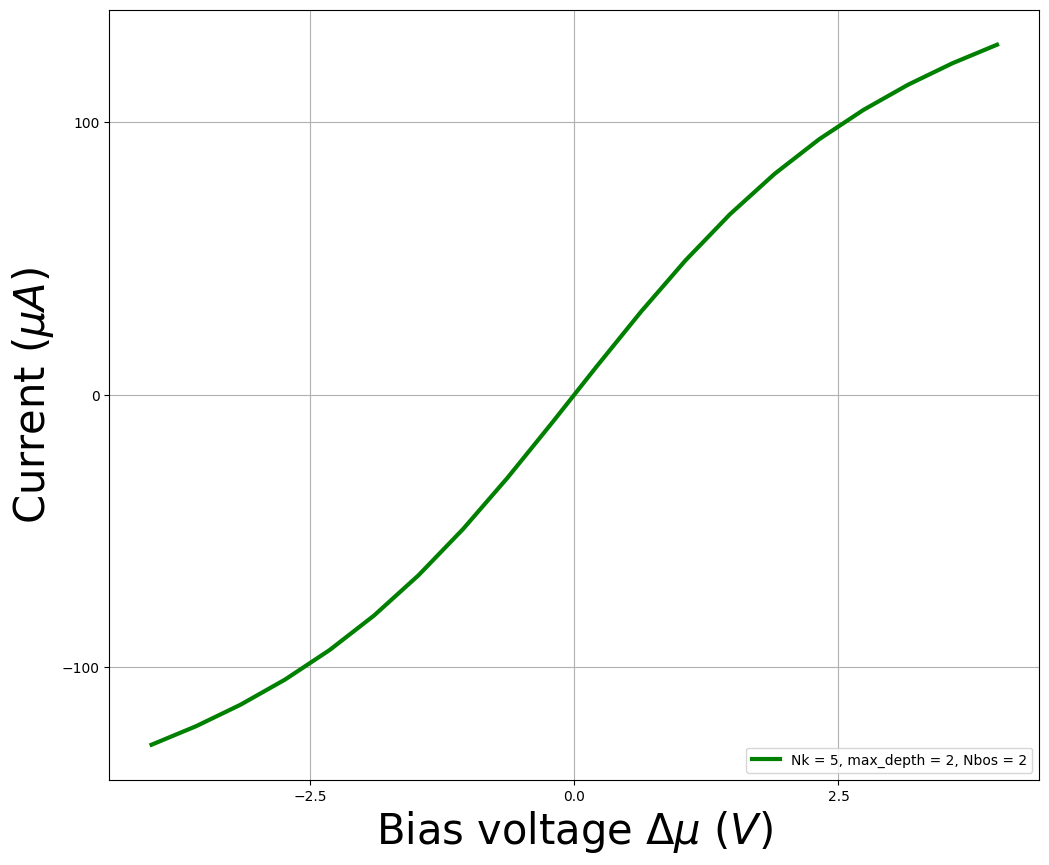

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(
    thetas, currents,
    color="green", linestyle='-', linewidth=3,
    label=f"Nk = {5}, max_depth = {Nc}, Nbos = {Nbos}",
)

#ax.set_yticks([0, 0.5, 1])
#ax.set_yticklabels([0, 0.5, 1])

ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

ax.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=30)
ax.set_ylabel(r"Current ($\mu A$)", fontsize=30)
ax.legend(loc=4);
plt.grid()
#plt.savefig("current_p.png")

In [11]:
G = np.gradient(currents, thetas)

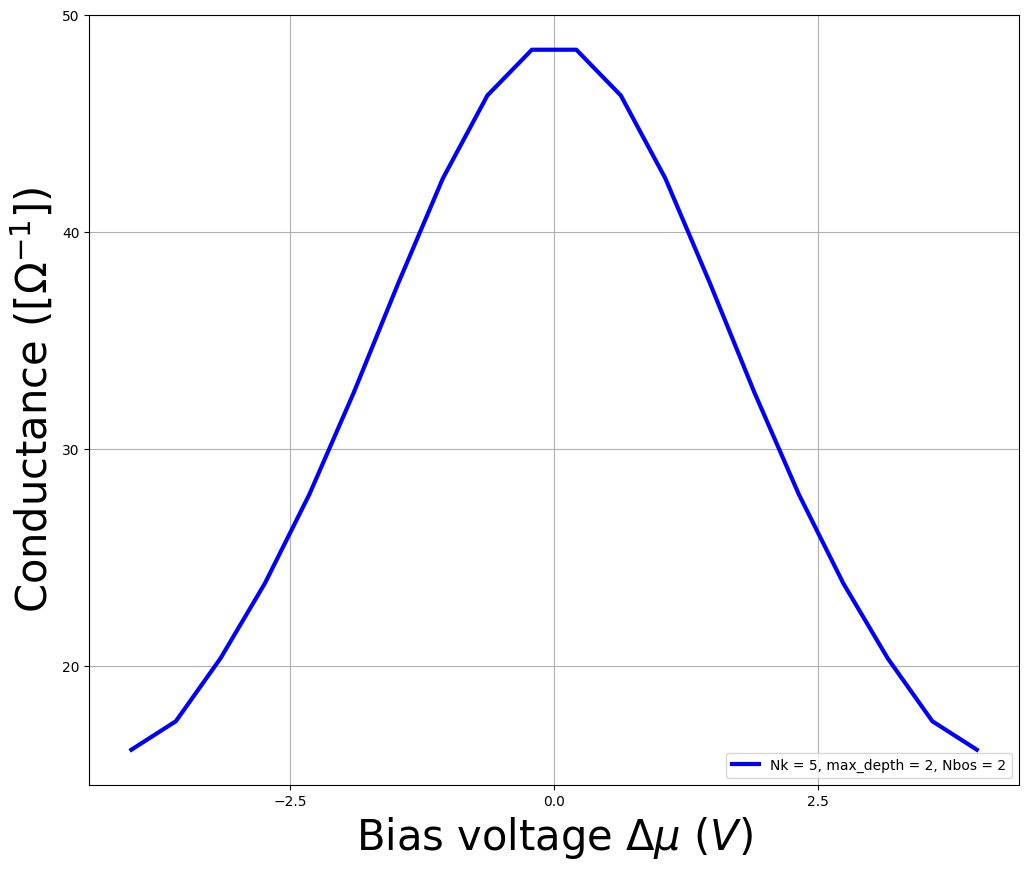

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(
    thetas, G,
    color="blue", linestyle='-', linewidth=3,
    label=f"Nk = {5}, max_depth = {Nc}, Nbos = {Nbos}"
)

#ax.set_yticks([0, 0.5, 1])
#ax.set_yticklabels([0, 0.5, 1])

ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

ax.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=30)
ax.set_ylabel(r"Conductance ($[\Omega^{-1}]$)", fontsize=30)
ax.legend(loc='lower right')

plt.grid()
#plt.savefig("conductance_p.png")